In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
filename = "CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv"
df = pd.read_csv(filename)

In [31]:
# downsample data
# n = 10
# num_lines = sum(1 for l in open(filename))
# to_skip = [x for x in range(1,num_lines) if x%n !=0]
# ds = pd.read_csv(filename, skiprows=to_skip)

In [79]:
df['datetime'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [88]:
days = df.daytype.unique().tolist()
stations = df.stationname.unique().tolist()
len(stations)

148

In [124]:
mparklist = ['Washington/Wabash', 'Clark/Lake']

In [157]:
def make_layered_hist(array, station, variablename, variablelist):
    fig, ax = plt.subplots()
    for var in variablelist:
        condarray = array[(array['stationname']==station) & (array[variablename]==var)]
        dist=sns.distplot(condarray['rides'], ax=ax, label=var)
        ax.legend()
        ax.set_xlabel('# of Rides Daily', fontsize=16)
    dist=dist.get_figure()
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_xlim([0,15000])
    plt.title('Distribution of ' + station + ' Rides', fontsize=20)
#     kde.savefig('figs/react_kde' + condDay + '.png')
#     plt.clf()

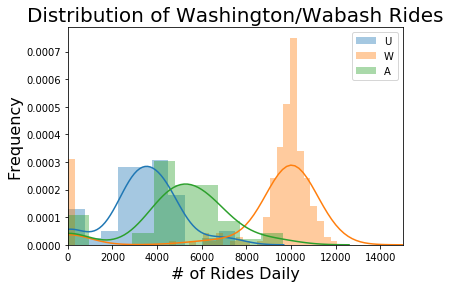

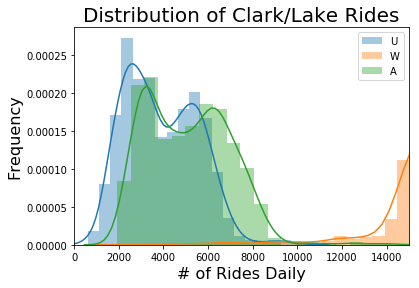

In [159]:
for park in mparklist:
    make_layered_hist(df, park, 'daytype', days)

In [93]:
y=pd.DataFrame(df_all.groupby(by=['stationname', 'daytype'])['rides'].mean())
y.loc[y.idxmax()]

,,rides
stationname,daytype,
Clark/Lake,W,17965.562822


In [116]:
stds = pd.DataFrame(index=stations, columns=['std'])
for station in stations:
    stds.loc[station,'std'] = (df.rides[df['stationname']==station].std())


In [123]:
stds

,std
UIC-Halsted,2387.55
Halsted-Orange,839.899
Granville,839.878
Jackson/Dearborn,2592.32
Damen-Brown,823.082
Damen/Milwaukee,1699.44
East 63rd-Cottage Grove,364.406
Austin-Lake,539.09
Cumberland,1434.05
35-Bronzeville-IIT,850.951
